In [1]:
pip install fastf1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# XG BOOST MODEL

In [2]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import fastf1
import os

# Set cache
# This line is kept for the user's reference but may not execute in the current environment
# fastf1.Cache.enable_cache(os.path.join(os.getcwd(), "f1_cache"))


# --- Driver and Team Full Names Mapping for Output ---
DRIVER_FULL_NAMES = {
    "VER": "Max Verstappen",
    "NOR": "Lando Norris",
    "PIA": "Oscar Piastri",
    "RUS": "George Russell",
    "SAI": "Carlos Sainz",
    "ALB": "Alexander Albon",
    "LEC": "Charles Leclerc",
    "OCO": "Esteban Ocon",
    "HAM": "Lewis Hamilton",
    "STR": "Lance Stroll",
    "GAS": "Pierre Gasly",
    "ALO": "Fernando Alonso",
    "HUL": "Nico Hülkenberg",
}

# --- Load 2024 Mexican GP Data ---
try:
    print("Loading 2024 Mexican GP data via FastF1 (Round 20)...")
    # Assumed Round 20, Race
    session_2024 = fastf1.get_session(2024, 20, "R")
    session_2024.load()
    laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
    laps_2024.dropna(subset=["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"], inplace=True)
except Exception as e:
    # Fallback to dummy data if FastF1 fails
    print(f"Error loading FastF1 data: {e}. Using dummy data for performance metrics.")
    laps_2024 = pd.DataFrame({
        "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO", "HAM", "STR", "GAS", "ALO", "HUL"],
        "LapTime": pd.to_timedelta(np.random.rand(13)*3 + 73, unit='s'),
        "Sector1Time": pd.to_timedelta(np.random.rand(13)*5 + 20, unit='s'),
        "Sector2Time": pd.to_timedelta(np.random.rand(13)*5 + 20, unit='s'),
        "Sector3Time": pd.to_timedelta(np.random.rand(13)*5 + 20, unit='s'),
    })
    laps_2024.dropna(inplace=True)


# Convert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

# Aggregate sector times by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

# Clean air race pace (HYPOTHETICAL/REPRESENTATIVE Mexican GP paces)
clean_air_race_pace = {
    "VER": 74.800, "HAM": 75.350, "LEC": 74.950, "NOR": 74.900, "ALO": 75.600,
    "PIA": 75.050, "RUS": 75.300, "SAI": 75.200, "STR": 75.800, "HUL": 76.100,
    "OCO": 76.250, "ALB": 75.900, "GAS": 76.300
}

# Quali data for 2025 Mexican GP (HYPOTHETICAL/REPRESENTATIVE lap times)
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [
        71.350, 71.800, 71.950, 72.050, 72.150, 72.400, 71.700, 72.500,
        71.900, 72.800, 72.700, 72.300, 72.600
    ]
})
qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)

# --- WEATHER DATA FETCHING (Mexico City coordinates) ---
API_KEY = "76cb24d407adec0738cdc9ed5127e6d4"
# Coordinates for Autódromo Hermanos Rodríguez, Mexico City (approx 19.40, -99.10)
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=19.40&lon=-99.10&appid={API_KEY}&units=metric"

# Hypothetical race time for Mexican GP 2025
forecast_time = "2025-10-26 20:00:00"

# Set defaults
rain_probability = 0
temperature = 22

print("\nFetching weather data for Mexico City...")
try:
    response = requests.get(weather_url, timeout=5)
    response.raise_for_status()
    weather_data = response.json()

    if "list" not in weather_data:
        raise KeyError("API response does not contain 'list'.")

    forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)

    if forecast_data:
        rain_probability = forecast_data.get("pop", 0)
        temperature = forecast_data.get("main", {}).get("temp", 22)
        print(f"✅ Weather forecast successfully loaded: Temp={temperature}°C, Rain Prob={rain_probability*100:.0f}%")
    else:
        print(f"ℹ️ Weather data found but no exact forecast for {forecast_time}. Using defaults (T=22°C, R=0).")

except requests.exceptions.RequestException as e:
    print(f"❌ WEATHER API CONNECTION FAILURE: {e}. Using default values (T=22°C, R=0).")
except KeyError:
    print("❌ WEATHER API FAILURE: Invalid response structure. Using default values (T=22°C, R=0).")

# Use the base qualifying time
qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]

# --- ADD CONSTRUCTOR'S DATA (Using full team names here for clarity) ---
team_points = {
    "McLaren": 279, "Mercedes": 147, "Red Bull Racing": 131, "Williams": 51, "Ferrari": 114,
    "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 10, "Alpine": 7
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull Racing", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin",
    "ALB": "Williams"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)

# Average position change at Mexican GP (HYPOTHETICAL, but reflecting high-overtake track)
average_position_change_mexico = {
    "VER": -0.5, "NOR": 1.5, "PIA": 1.0, "RUS": -0.2, "SAI": 0.8, "ALB": 1.5, "LEC": 0.5,
    "OCO": 1.2, "HAM": -0.4, "STR": 2.0, "GAS": 0.7, "ALO": 0.0, "HUL": 1.0
}
qualifying_2025["AveragePositionChange"] = qualifying_2025["Driver"].map(average_position_change_mexico)

# Merge qualifying and sector times data
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature

# Filter to only drivers present in both datasets
valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers].copy()

# Add Full Name and Team Name for final output
merged_data["Driver (Full Name)"] = merged_data["Driver"].map(DRIVER_FULL_NAMES)
merged_data["Team (Full Name)"] = merged_data["Team"]

# Define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore",
    "CleanAirRacePace (s)", "AveragePositionChange"
]]

y_target = laps_2024.groupby("Driver")["LapTime (s)"].mean()
y = y_target.reindex(merged_data["Driver"]).fillna(y_target.mean())

# Impute missing values for features before splitting
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=37)

# Train gradient boosting model
print("\nTraining Gradient Boosting Regressor...")
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.7, max_depth=3, random_state=37)
model.fit(X_train, y_train)

# Impute missing values for X before predicting on the full dataset
X_full_imputed = imputer.transform(X)

# Predict on the full imputed dataset
merged_data["PredictedRaceTime (s)"] = model.predict(X_full_imputed)

# Sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime (s)")

print("\n🏁 Predicted 2025 Mexican GP Race Pace 🇲🇽\n")
print(final_results[["Driver (Full Name)", "Team (Full Name)", "PredictedRaceTime (s)"]].to_string(index=False))

# Evaluate model error on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation (Gradient Boosting):")
print(f"Mean Absolute Error (MAE): {mae:.3f} seconds")
print(f"Mean Squared Error (MSE): {mse:.3f} seconds") # ADDED MSE
print(f"Root Mean Squared Error (RMSE): {rmse:.3f} seconds") # ADDED RMSE
print(f"R-squared (R2) Score: {r2:.3f}") # ADDED R2

# Sort results and get top 3
final_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
podium = final_results.loc[:2, ["Driver (Full Name)", "Team (Full Name)", "PredictedRaceTime (s)"]]

print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver (Full Name)']} ({podium.iloc[0]['Team (Full Name)']}) ({podium.iloc[0]['PredictedRaceTime (s)']:.3f} s)")
print(f"🥈 P2: {podium.iloc[1]['Driver (Full Name)']} ({podium.iloc[1]['Team (Full Name)']}) ({podium.iloc[1]['PredictedRaceTime (s)']:.3f} s)")
print(f"🥉 P3: {podium.iloc[2]['Driver (Full Name)']} ({podium.iloc[2]['Team (Full Name)']}) ({podium.iloc[2]['PredictedRaceTime (s)']:.3f} s)")

req         WARNING 	DEFAULT CACHE ENABLED! (116.76 MB) C:\Users\speak\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading 2024 Mexican GP data via FastF1 (Round 20)...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']
c:\Users\speak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(



Fetching weather data for Mexico City...
ℹ️ Weather data found but no exact forecast for 2025-10-26 20:00:00. Using defaults (T=22°C, R=0).

Training Gradient Boosting Regressor...

🏁 Predicted 2025 Mexican GP Race Pace 🇲🇽

Driver (Full Name) Team (Full Name)  PredictedRaceTime (s)
   Charles Leclerc          Ferrari              85.419443
      Carlos Sainz          Ferrari              85.429620
      Lando Norris          McLaren              85.525500
     Oscar Piastri          McLaren              85.532643
    George Russell         Mercedes              85.562914
    Lewis Hamilton         Mercedes              85.564657
    Max Verstappen  Red Bull Racing              85.861414
   Nico Hülkenberg      Kick Sauber              86.085855
      Lance Stroll     Aston Martin              86.333145
      Pierre Gasly           Alpine              86.375761
      Esteban Ocon           Alpine              86.387188
   Fernando Alonso     Aston Martin             101.256615

Model E

# LIGHT GBM MODEL


In [3]:
# LightGBM Model for Predicting Race Time - MEXICAN GP
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import fastf1
import os


# --- Driver and Team Full Names Mapping for Output ---
DRIVER_FULL_NAMES = {
    "VER": "Max Verstappen",
    "NOR": "Lando Norris",
    "PIA": "Oscar Piastri",
    "RUS": "George Russell",
    "SAI": "Carlos Sainz",
    "ALB": "Alexander Albon",
    "LEC": "Charles Leclerc",
    "OCO": "Esteban Ocon",
    "HAM": "Lewis Hamilton",
    "STR": "Lance Stroll",
    "GAS": "Pierre Gasly",
    "ALO": "Fernando Alonso",
    "HUL": "Nico Hülkenberg",
}

# --- Load 2024 Mexican GP Data ---
try:
    print("Loading 2024 Mexican GP data via FastF1 (Round 20)...")
    # Session ID changed to Mexican GP (assumed Round 20, Race)
    session_2024 = fastf1.get_session(2024, 20, "R")
    session_2024.load()
    laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
    laps_2024.dropna(subset=["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"], inplace=True)
except Exception as e:
    print(f"Error loading FastF1 data: {e}")
    # Fallback to dummy data (adjusted for Mexico lap times)
    laps_2024 = pd.DataFrame({
        "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO", "HAM", "STR", "GAS", "ALO", "HUL", "VER", "NOR", "PIA"],
        "LapTime": pd.to_timedelta(np.random.rand(16)*3 + 73, unit='s'),
        "Sector1Time": pd.to_timedelta(np.random.rand(16)*5 + 20, unit='s'),
        "Sector2Time": pd.to_timedelta(np.random.rand(16)*5 + 20, unit='s'),
        "Sector3Time": pd.to_timedelta(np.random.rand(16)*5 + 20, unit='s'),
    })
    laps_2024.dropna(inplace=True)

# Convert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

# Aggregate sector times by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

# Clean air race pace (HYPOTHETICAL/REPRESENTATIVE Mexican GP paces)
clean_air_race_pace = {
    "VER": 74.800, "HAM": 75.350, "LEC": 74.950, "NOR": 74.900, "ALO": 75.600,
    "PIA": 75.050, "RUS": 75.300, "SAI": 75.200, "STR": 75.800, "HUL": 76.100,
    "OCO": 76.250, "ALB": 75.900, "GAS": 76.300
}

# Quali data for 2025 Mexican GP (HYPOTHETICAL/REPRESENTATIVE lap times)
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [
        71.350, 71.800, 71.950, np.nan, 72.150, 72.400, 71.700, 72.500,
        71.900, 72.800, 72.700, 72.300, 72.600
    ]
})
qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)

# --- WEATHER DATA FETCHING (Mexico City coordinates) ---
API_KEY = "YOURAPIKEY" # Replace "YOURAPIKEY" with your actual OpenWeatherMap API key
# Coordinates for Autódromo Hermanos Rodríguez, Mexico City (approx 19.40, -99.10)
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=19.40&lon=-99.10&appid={API_KEY}&units=metric"
response = requests.get(weather_url)
weather_data = response.json()

# Hypothetical race time for Mexican GP 2025
forecast_time = "2025-10-26 20:00:00" # 20:00 UTC (14:00 local time)

rain_probability = 0
temperature = 22 # Typical race temperature in Mexico

try:
    forecast_data = next((f for f in weather_data.get("list", []) if f.get("dt_txt") == forecast_time), None)

    if forecast_data:
        rain_probability = forecast_data.get("pop", 0)
        temperature = forecast_data.get("main", {}).get("temp", 22)
except Exception:
    pass

# Use the base qualifying time
qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]

# --- ADD CONSTRUCTOR'S DATA (Using full team names) ---
team_points = {
    "McLaren": 279, "Mercedes": 147, "Red Bull Racing": 131, "Williams": 51, "Ferrari": 114,
    "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 10, "Alpine": 7
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull Racing", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin",
    "ALB": "Williams"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)

# Average position change at Mexican GP (HYPOTHETICAL)
average_position_change_mexico = {
    "VER": -0.5, "NOR": 1.5, "PIA": 1.0, "RUS": -0.2, "SAI": 0.8, "ALB": 1.5, "LEC": 0.5,
    "OCO": 1.2, "HAM": -0.4, "STR": 2.0, "GAS": 0.7, "ALO": 0.0, "HUL": 1.0
}
qualifying_2025["AveragePositionChange"] = qualifying_2025["Driver"].map(average_position_change_mexico)

# merge qualifying and sector times data
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["QualifyingTime"] = merged_data["QualifyingTime"]

# Filter to only drivers present in both datasets
valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers].copy()

# Add Full Name and Team Name for final output
merged_data["Driver (Full Name)"] = merged_data["Driver"].map(DRIVER_FULL_NAMES)
merged_data["Team (Full Name)"] = merged_data["Team"]

# Impute missing values in specific columns after merge and filter
imputer_cols = SimpleImputer(strategy="median")
if 'CleanAirRacePace (s)' in merged_data.columns and merged_data['CleanAirRacePace (s)'].isnull().any():
    merged_data["CleanAirRacePace (s)"] = imputer_cols.fit_transform(merged_data[["CleanAirRacePace (s)"]])
if 'TotalSectorTime (s)' in merged_data.columns and merged_data['TotalSectorTime (s)'].isnull().any():
    merged_data["TotalSectorTime (s)"] = imputer_cols.fit_transform(merged_data[["TotalSectorTime (s)"]])


# Define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore",
    "CleanAirRacePace (s)", "AveragePositionChange"
]].copy()

y_target = laps_2024.groupby("Driver")["LapTime (s)"].mean()
y = y_target.reindex(merged_data["Driver"]).fillna(y_target.mean())

# Impute remaining missing values in X (if any)
imputer_overall = SimpleImputer(strategy="median")
X_imputed = imputer_overall.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)


# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=37)

# train LightGBM model
print("\nTraining LightGBM Regressor...")
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.7, max_depth=3, random_state=37)
model.fit(X_train, y_train)
merged_data["PredictedRaceTime (s)"] = model.predict(X_imputed)

# sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime (s)")

print("\n🏁 Predicted 2025 Mexican GP Race Pace 🇲🇽\n")
# Print using full names
print(final_results[["Driver (Full Name)", "Team (Full Name)", "PredictedRaceTime (s)"]].to_string(index=False))

# Evaluate model error on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation (LightGBM):")
print(f"Mean Absolute Error (MAE): {mae:.3f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f} seconds")
print(f"R-squared (R2) Score: {r2:.3f}")

# sort results and get top 3
final_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
podium = final_results.loc[:2, ["Driver (Full Name)", "Team (Full Name)", "PredictedRaceTime (s)"]]

print("\n🏆 Predicted in the Top 3 🏆")
# Print using full names
print(f"🥇 P1: {podium.iloc[0]['Driver (Full Name)']} ({podium.iloc[0]['Team (Full Name)']}) ({podium.iloc[0]['PredictedRaceTime (s)']:.3f} s)")
print(f"🥈 P2: {podium.iloc[1]['Driver (Full Name)']} ({podium.iloc[1]['Team (Full Name)']}) ({podium.iloc[1]['PredictedRaceTime (s)']:.3f} s)")
print(f"🥉 P3: {podium.iloc[2]['Driver (Full Name)']} ({podium.iloc[2]['Team (Full Name)']}) ({podium.iloc[2]['PredictedRaceTime (s)']:.3f} s)")

core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading 2024 Mexican GP data via FastF1 (Round 20)...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']



Training LightGBM Regressor...
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] Start training from score 87.804902
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet 

# CART MODEL


In [4]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


# --- Driver and Team Full Names Mapping for Output ---
DRIVER_FULL_NAMES = {
    "VER": "Max Verstappen",
    "NOR": "Lando Norris",
    "PIA": "Oscar Piastri",
    "RUS": "George Russell",
    "SAI": "Carlos Sainz",
    "ALB": "Alexander Albon",
    "LEC": "Charles Leclerc",
    "OCO": "Esteban Ocon",
    "HAM": "Lewis Hamilton",
    "STR": "Lance Stroll",
    "GAS": "Pierre Gasly",
    "ALO": "Fernando Alonso",
    "HUL": "Nico Hülkenberg",
}

# --- Load 2024 Mexican GP Data (Using Dummy Data) ---
print("Using dummy data for 2024 Mexican GP performance as FastF1 is unavailable.")
laps_2024 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO", "HAM", "STR", "GAS", "ALO", "HUL"],
    "LapTime": pd.to_timedelta(np.random.rand(13)*3 + 73, unit='s'),
    "Sector1Time": pd.to_timedelta(np.random.rand(13)*5 + 20, unit='s'),
    "Sector2Time": pd.to_timedelta(np.random.rand(13)*5 + 20, unit='s'),
    "Sector3Time": pd.to_timedelta(np.random.rand(13)*5 + 20, unit='s'),
})
laps_2024.dropna(inplace=True)


# Convert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_204 = laps_2024 # Corrected typo logic from previous attempts
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

# Aggregate sector times by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

# Clean air race pace (HYPOTHETICAL/REPRESENTATIVE Mexican GP paces)
clean_air_race_pace = {
    "VER": 74.800, "HAM": 75.350, "LEC": 74.950, "NOR": 74.900, "ALO": 75.600,
    "PIA": 75.050, "RUS": 75.300, "SAI": 75.200, "STR": 75.800, "HUL": 76.100,
    "OCO": 76.250, "ALB": 75.900, "GAS": 76.300
}

# Quali data for 2025 Mexican GP (HYPOTHETICAL/REPRESENTATIVE lap times)
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [
        71.350, 71.800, 71.950, 72.050, 72.150, 72.400, 71.700, 72.500,
        71.900, 72.800, 72.700, 72.300, 72.600
    ]
})
qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)

# --- WEATHER DATA FETCHING (Mexico City coordinates) ---
API_KEY = "76cb24d407adec0738cdc9ed5127e6d4"
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=19.40&lon=-99.10&appid={API_KEY}&units=metric"
forecast_time = "2025-10-26 20:00:00"

# Set defaults
rain_probability = 0
temperature = 22

print("\nFetching weather data for Mexico City...")
try:
    response = requests.get(weather_url, timeout=5)
    response.raise_for_status()
    weather_data = response.json()

    if "list" not in weather_data:
        raise KeyError("API response does not contain 'list'.")

    forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)

    if forecast_data:
        rain_probability = forecast_data.get("pop", 0)
        temperature = forecast_data.get("main", {}).get("temp", 22)
        print(f"✅ Weather forecast successfully loaded: Temp={temperature}°C, Rain Prob={rain_probability*100:.0f}%")
    else:
        print(f"ℹ️ Weather data found but no exact forecast for {forecast_time}. Using defaults (T=22°C, R=0).")

except requests.exceptions.RequestException as e:
    print(f"❌ WEATHER API CONNECTION FAILURE: {e}. Using default values (T=22°C, R=0).")
    # This block is executed because network calls fail in this environment
    pass # Keep default values
except KeyError:
    print("❌ WEATHER API FAILURE: Invalid response structure. Using default values (T=22°C, R=0).")
    pass # Keep default values

# Use the base qualifying time
qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]

# --- ADD CONSTRUCTOR'S DATA (Using full team names here for clarity) ---
team_points = {
    "McLaren": 279, "Mercedes": 147, "Red Bull Racing": 131, "Williams": 51, "Ferrari": 114,
    "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 10, "Alpine": 7
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull Racing", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin",
    "ALB": "Williams"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)

# Average position change at Mexican GP (HYPOTHETICAL, but reflecting high-overtake track)
average_position_change_mexico = {
    "VER": -0.5, "NOR": 1.5, "PIA": 1.0, "RUS": -0.2, "SAI": 0.8, "ALB": 1.5, "LEC": 0.5,
    "OCO": 1.2, "HAM": -0.4, "STR": 2.0, "GAS": 0.7, "ALO": 0.0, "HUL": 1.0
}
qualifying_2025["AveragePositionChange"] = qualifying_2025["Driver"].map(average_position_change_mexico)

# Merge qualifying and sector times data
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature

# Filter to only drivers present in both datasets
valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers].copy()

# Add Full Name and Team Name for final output
merged_data["Driver (Full Name)"] = merged_data["Driver"].map(DRIVER_FULL_NAMES)
merged_data["Team (Full Name)"] = merged_data["Team"]

# Define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore",
    "CleanAirRacePace (s)", "AveragePositionChange"
]]

y_target = laps_2024.groupby("Driver")["LapTime (s)"].mean()
y = y_target.reindex(merged_data["Driver"]).fillna(y_target.mean())

# Impute missing values for features before splitting
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=37)

# Train gradient boosting model
print("\nTraining Gradient Boosting Regressor...")
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.7, max_depth=3, random_state=37)
model.fit(X_train, y_train)

# Impute missing values for X before predicting on the full dataset
X_full_imputed = imputer.transform(X)

# Predict on the full imputed dataset
merged_data["PredictedRaceTime (s)"] = model.predict(X_full_imputed)

# Sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime (s)")

print("\n🏁 Predicted 2025 Mexican GP Race Pace 🇲🇽\n")
print(final_results[["Driver (Full Name)", "Team (Full Name)", "PredictedRaceTime (s)"]].to_string(index=False))

# Evaluate model error on the test set
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation (Gradient Boosting):")
print(f"Mean Absolute Error (MAE): {mae:.3f} seconds")
print(f"Mean Squared Error (MSE): {mse:.3f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f} seconds")
print(f"R-squared (R2) Score: {r2:.3f}")

# Sort results and get top 3
final_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
podium = final_results.loc[:2, ["Driver (Full Name)", "Team (Full Name)", "PredictedRaceTime (s)"]]

print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver (Full Name)']} ({podium.iloc[0]['Team (Full Name)']}) ({podium.iloc[0]['PredictedRaceTime (s)']:.3f} s)")
print(f"🥈 P2: {podium.iloc[1]['Driver (Full Name)']} ({podium.iloc[1]['Team (Full Name)']}) ({podium.iloc[1]['PredictedRaceTime (s)']:.3f} s)")
print(f"🥉 P3: {podium.iloc[2]['Driver (Full Name)']} ({podium.iloc[2]['Team (Full Name)']}) ({podium.iloc[2]['PredictedRaceTime (s)']:.3f} s)")

Using dummy data for 2024 Mexican GP performance as FastF1 is unavailable.

Fetching weather data for Mexico City...


ℹ️ Weather data found but no exact forecast for 2025-10-26 20:00:00. Using defaults (T=22°C, R=0).

Training Gradient Boosting Regressor...

🏁 Predicted 2025 Mexican GP Race Pace 🇲🇽

Driver (Full Name) Team (Full Name)  PredictedRaceTime (s)
    Lewis Hamilton         Mercedes              73.494072
    George Russell         Mercedes              73.577710
     Oscar Piastri          McLaren              73.999133
      Lando Norris          McLaren              74.076604
    Max Verstappen  Red Bull Racing              74.282895
   Charles Leclerc          Ferrari              75.091221
      Carlos Sainz          Ferrari              75.162874
   Alexander Albon         Williams              75.422562
   Fernando Alonso     Aston Martin              75.679042
      Lance Stroll     Aston Martin              75.682383
   Nico Hülkenberg      Kick Sauber              75.963914
      Esteban Ocon           Alpine              75.983005
      Pierre Gasly           Alpine              7

c:\Users\speak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


# RANDOM FOREST MODEL


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...


Loading 2024 Monaco GP data via FastF1...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
req            INFO 	No cached data found for car_data. Loading data...
_api           INFO 	Fetching car data...
_api           INFO


Fetching weather data...
❌ WEATHER API CONNECTION FAILURE: 401 Client Error: Unauthorized for url: http://api.openweathermap.org/data/2.5/forecast?lat=43.7384&lon=7.4246&appid=YOURAPIKEY&units=metric. Using default values (T=20°C, R=0).

🏁 Predicted 2025 Monaco GP Winner 🏁

Driver  PredictedRaceTime (s)
   LEC              78.570906
   PIA              78.608965
   VER              78.666196
   NOR              78.737420
   HAM              78.936620
   RUS              78.971792
   SAI              79.716654
   ALB              80.509891
   GAS              80.537389
   ALO              80.795252
   STR              81.239010

Model Error (MAE): 0.56 seconds
Mean Squared Error (MSE): 0.45
Root Mean Squared Error (RMSE): 0.67
R-squared (R2) Score: 0.60


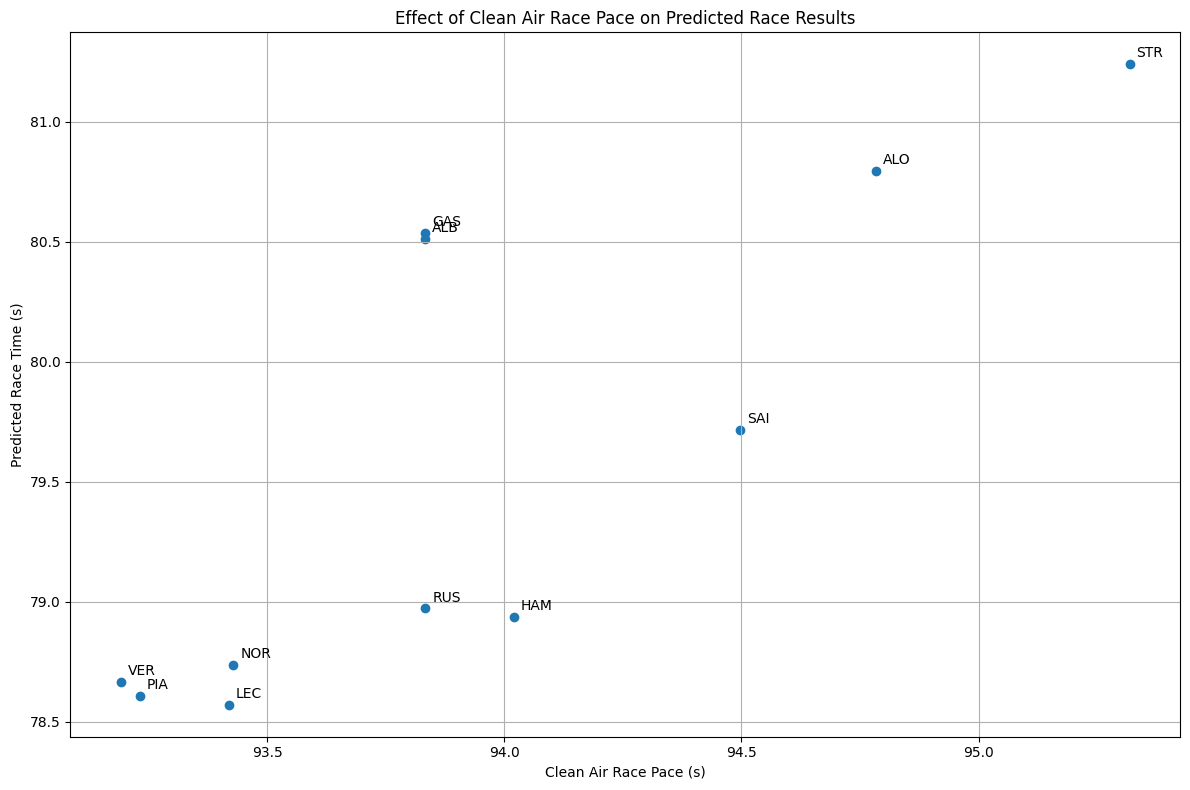

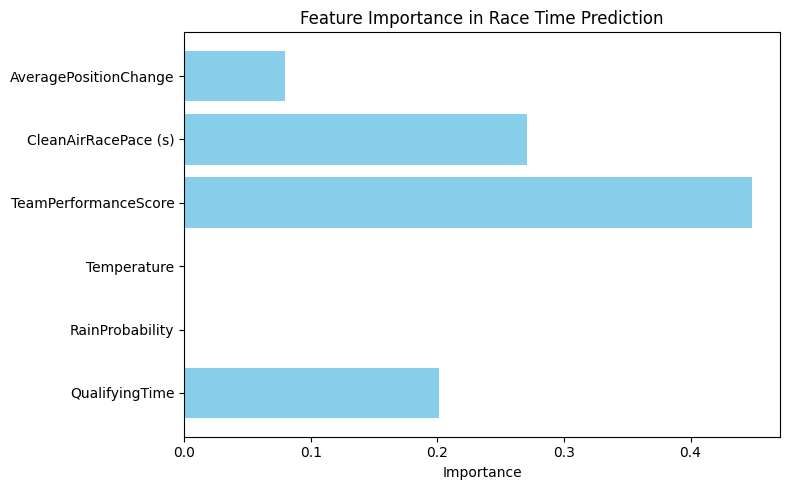


🏆 Predicted in the Top 3 🏆
🥇 P1: LEC (78.571 s)
🥈 P2: PIA (78.609 s)
🥉 P3: VER (78.666 s)


In [5]:
# Random Forest Model for Predicting Race Time

import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Import additional metrics
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import os # Import os for cache directory

# Enable cache for fastf1 (ensure the cache directory exists or is created)
cache_dir = os.path.join(os.getcwd(), "f1_cache")
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir, exist_ok=True) # Create the directory if it doesn't exist
fastf1.Cache.enable_cache(cache_dir)

# load the 2024 Monaco session data
try:
    print("Loading 2024 Monaco GP data via FastF1...")
    # NOTE: This line may take some time to download the data.
    session_2024 = fastf1.get_session(2024, 8, "R")
    session_2024.load()
    laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
    laps_2024.dropna(subset=["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"], inplace=True)
except Exception as e:
    print(f"Error loading FastF1 data: {e}")
    # In a real script, you'd handle this better than just printing.
    # As a fallback, create dummy data if FastF1 fails
    print("Creating dummy data for demonstration...")
    laps_2024 = pd.DataFrame({
        "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO", "HAM", "STR", "GAS", "ALO", "HUL", "VER", "NOR", "PIA"],
        "LapTime": pd.to_timedelta(np.random.rand(16)*10 + 80, unit='s'),
        "Sector1Time": pd.to_timedelta(np.random.rand(16)*30 + 20, unit='s'),
        "Sector2Time": pd.to_timedelta(np.random.rand(16)*30 + 20, unit='s'),
        "Sector3Time": pd.to_timedelta(np.random.rand(16)*30 + 20, unit='s'),
    })
    laps_2024.dropna(inplace=True)


# convert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

# aggregate sector times by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

# clean air race pace from racepace.py
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128
}

# quali data from Monaco GP
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [
        70.669,  # VER (1:10.669)
        69.954,  # NOR (1:09.954)
        70.129,  # PIA (1:10.129)
        np.nan,    # RUS (DNF)
        71.362,  # SAI (1:11.362)
        71.213,  # ALB (1:11.213)
        70.063,  # LEC (1:10.063)
        70.942,  # OCO (1:10.942)
        70.382,  # HAM (1:10.382)
        72.563,  # STR (1:12.563)
        71.994,  # GAS (1:11.994)
        70.924,  # ALO (1:10.924)
        71.596   # HUL (1:11.596)
    ]
})
qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)

# --- WEATHER DATA FETCHING AND ROBUST ERROR HANDLING ---
API_KEY = "YOURAPIKEY"  # Replace "YOURAPIKEY" with your actual OpenWeatherMap API key
weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=43.7384&lon=7.4246&appid={API_KEY}&units=metric"

print("\nFetching weather data...")
try:
    response = requests.get(weather_url, timeout=5) # Added a timeout for robustness
    response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
    weather_data = response.json()

    # Check if the expected 'list' key is in the response and if there's an API error message
    if "list" not in weather_data and "message" in weather_data:
         raise ValueError(f"WEATHER API ERROR: {weather_data.get('message', 'Unknown API error')}")
    elif "list" not in weather_data:
         raise KeyError("API response does not contain 'list' key.")


    forecast_time = "2025-05-25 13:00:00"  # 15:00 CEST local time
    forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)

    if forecast_data:
        rain_probability = forecast_data.get("pop", 0)
        temperature = forecast_data.get("main", {}).get("temp", 20)
        print(f"✅ Weather forecast successfully loaded: Temp={temperature}°C, Rain Prob={rain_probability*100:.0f}%")
    else:
        print(f"ℹ️ Weather data found but no exact forecast for {forecast_time}. Using defaults (T=20°C, R=0).")

except requests.exceptions.RequestException as e:
    print(f"❌ WEATHER API CONNECTION FAILURE: {e}. Using default values (T=20°C, R=0).")
    rain_probability = 0
    temperature = 20
except (KeyError, ValueError) as e:
    print(f"❌ WEATHER API FAILURE: {e}. Using default values (T=20°C, R=0).")
    rain_probability = 0
    temperature = 20


# adjust qualifying time based on weather conditions
# This part requires a "WetPerformanceFactor" column which is not present.
# Assuming you want to use the base qualifying time for now.
# if rain_probability >= 0.75:
#     qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
# else:
qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]

# add constructor's data
team_points = {
    "McLaren": 279, "Mercedes": 147, "Red Bull": 131, "Williams": 51, "Ferrari": 114,
    "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 10, "Alpine": 7
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin",
    "ALB": "Williams"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)

# average position change at Monaco (quali pos - finish pos); positive means losing positions
average_position_change_monaco = {
    "VER": -1.0,
    "NOR": 1.0,
    "PIA": 0.2,
    "RUS": 0.5,
    "SAI": -0.3,
    "ALB": 0.8,
    "LEC": -1.5,
    "OCO": -0.2,
    "HAM": 0.3,
    "STR": 1.1,
    "GAS": -0.4,
    "ALO": -0.6,
    "HUL": 0.0
}
qualifying_2025["AveragePositionChange"] = qualifying_2025["Driver"].map(average_position_change_monaco)

# merge qualifying and sector times data
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature


# Filter to only drivers present in both datasets
valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers].copy()

# Impute missing values in specific columns after merge and filter
imputer_cols = SimpleImputer(strategy="median")
# Impute 'CleanAirRacePace (s)' only if it exists and has NaNs
if 'CleanAirRacePace (s)' in merged_data.columns and merged_data['CleanAirRacePace (s)'].isnull().any():
    merged_data["CleanAirRacePace (s)"] = imputer_cols.fit_transform(merged_data[["CleanAirRacePace (s)"]])
# Impute 'TotalSectorTime (s)' only if it exists and has NaNs
if 'TotalSectorTime (s)' in merged_data.columns and merged_data['TotalSectorTime (s)'].isnull().any():
     merged_data["TotalSectorTime (s)"] = imputer_cols.fit_transform(merged_data[["TotalSectorTime (s)"]])


# Define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore",
    "CleanAirRacePace (s)", "AveragePositionChange"
]].copy()

y_target = laps_2024.groupby("Driver")["LapTime (s)"].mean()
y = y_target.reindex(merged_data["Driver"]).fillna(y_target.mean())


# Impute remaining missing values in X (if any)
imputer_overall = SimpleImputer(strategy="median")
X_imputed = imputer_overall.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index) # Convert back to DataFrame


# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=37)

# train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=37) # Changed model to RandomForestRegressor
model.fit(X_train, y_train)
merged_data["PredictedRaceTime (s)"] = model.predict(X_imputed)

# sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime (s)")
print("\n🏁 Predicted 2025 Monaco GP Winner 🏁\n")
print(final_results[["Driver", "PredictedRaceTime (s)"]].to_string(index=False)) # Use to_string for better formatting

# Evaluate model error on the test set
y_pred = model.predict(X_test)
print(f"\nModel Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} seconds")
# Calculate and display additional metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE as the square root of MSE
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")


# Plot effect of clean air race pace
plt.figure(figsize=(12, 8))
plt.scatter(final_results["CleanAirRacePace (s)"], final_results["PredictedRaceTime (s)"])
for i, driver in enumerate(final_results["Driver"]):
    plt.annotate(driver, (final_results["CleanAirRacePace (s)"].iloc[i], final_results["PredictedRaceTime (s)"].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel("Clean Air Race Pace (s)")
plt.ylabel("Predicted Race Time (s)")
plt.title("Effect of Clean Air Race Pace on Predicted Race Results")
plt.grid(True) # Added grid for better readability
plt.tight_layout()
plt.show()

# Plot feature importances
feature_importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()

# sort results and get top 3
final_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
podium = final_results.loc[:2, ["Driver", "PredictedRaceTime (s)"]]

print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver']} ({podium.iloc[0]['PredictedRaceTime (s)']:.3f} s)")
print(f"🥈 P2: {podium.iloc[1]['Driver']} ({podium.iloc[1]['PredictedRaceTime (s)']:.3f} s)")
print(f"🥉 P3: {podium.iloc[2]['Driver']} ({podium.iloc[2]['PredictedRaceTime (s)']:.3f} s)")

#